Для воспроизводимости кода установим определенную версию tensorflow и keras

In [ ]:
!pip install -q tensorflow==2.1

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.backend import clear_session
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
print("We're using TF", tf.__version__)
print("We are using Keras", keras.__version__)

We're using TF 2.15.0


AttributeError: module 'keras._tf_keras.keras' has no attribute '__version__'

In [6]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

2024-02-19 13:25:09.719289: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-19 13:25:09.719500: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


''

In [7]:
#GPU count and name
!nvidia-smi -L

104.66s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


GPU 0: NVIDIA GeForce GTX 1650 (UUID: GPU-30f47986-5729-12bd-822a-7eea56693ef3)


In [8]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

111.61s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Mon Feb 19 13:25:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650        Off | 00000000:01:00.0  On |                  N/A |
| 13%   49C    P8              11W /  75W |   1072MiB /  4096MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# MNIST

In [9]:
# скачиваем данные
# (x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

In [10]:
# что за данные
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[9 0 0 3 0 2 7 2 5 5]
[9 2 1 1 6 1 4 6 5 7]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


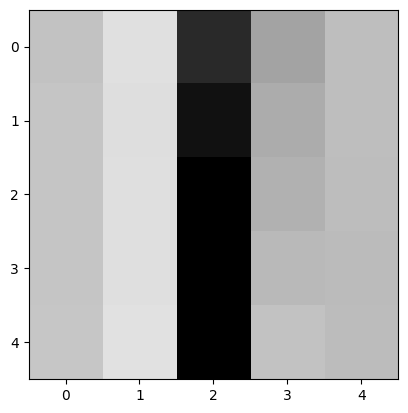

Пример картинки:


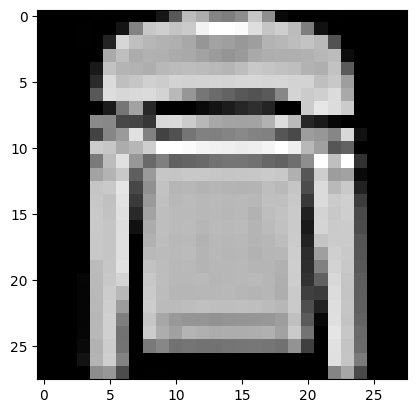

y_train [shape (60000,)] 10 примеров:
 [9 0 0 3 0 2 7 2 5 5]


In [13]:
# нарисуем картинку
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

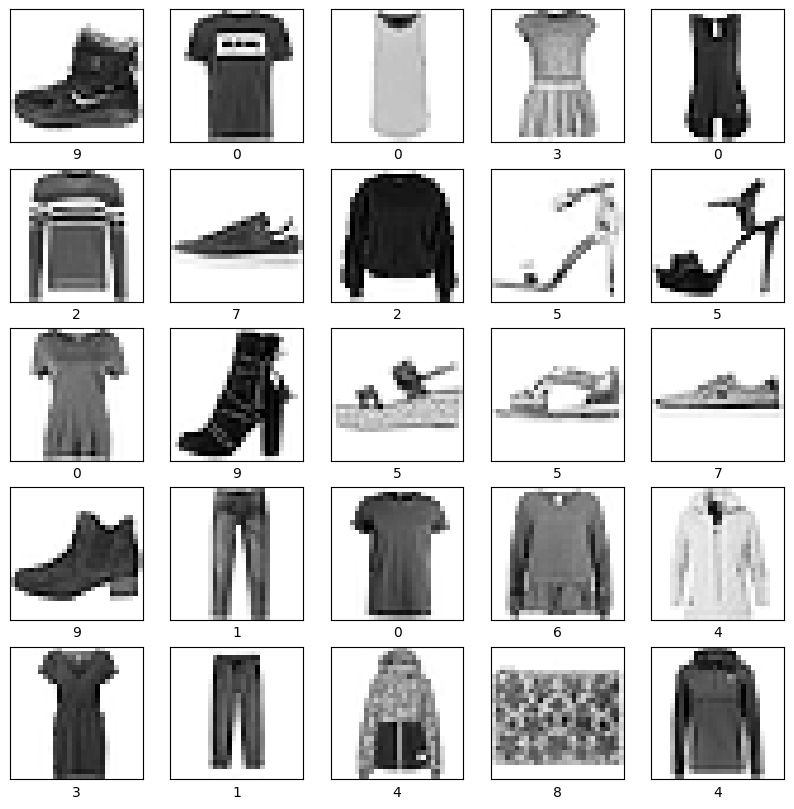

In [14]:
# Посмотрим побольше примеров
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(y_train[i])
plt.show()

# Data

In [41]:
# вытянем картинку в вектор размера 28*28=784 и будем использовать это как фичи!

x_train_float = x_train.reshape(-1, 28*28).astype(float)
print(x_train.shape, x_train_flat.shape)

x_val_float = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)


In [42]:
# # центрируем и нормируем, так сети будет проще учиться
# # x_train_float = x_train_flat.astype(np.float) / 255 - 0.5
# # x_val_float = x_val_flat.astype(np.float) / 255 - 0.5

# # по сути, это действия аналогичны нормализации через StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_flat = scaler.fit_transform(x_train_flat)
x_val_flat = scaler.transform(x_val_flat)

# # Но попробуйте пропустить нормирование и посмотрите что будет ;)
# x_train_float = x_train_flat.astype(np.float)
# x_val_float = x_val_flat.astype(np.float)

In [43]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9 0 0 3 0]


# Собираем модель

Самостоятельно постойте Multi layer Perceptron (MLP) классификатор (по аналогии с практическеской частью, но на новых данных)

In [70]:
clear_session()

In [75]:
# Тут ваш код Архитектуры сети
# не забудьте 10 выходов с активацией softmax на выходном слое!
# model = Sequential()
# model.add(Dense(..., input_shape=(28*28,))) # первый скрытый слой
# ...

model = Sequential()
model.add(Dense(units = 128, input_shape = (28 * 28,)))
model.add(Dense(units = 128))

model.add(Dense(units = 10, activation = 'softmax'))

In [76]:
# model.summary() используется для вывода сводки (summary) архитектуры модели нейронной сети. 
# Эта сводка предоставляет информацию о количестве параметров модели и форме выхода каждого слоя.
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)               │    100,480 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 10)                │      1,290 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [78]:
history = model.fit(
                    x_train_float, 
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=10,  # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7156 - loss: 26.5055 - val_accuracy: 0.7643 - val_loss: 3.2310
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7586 - loss: 3.2846 - val_accuracy: 0.7548 - val_loss: 2.8505
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7574 - loss: 2.9431 - val_accuracy: 0.7463 - val_loss: 2.6878
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7586 - loss: 2.6378 - val_accuracy: 0.7763 - val_loss: 2.0059
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7668 - loss: 2.1387 - val_accuracy: 0.7410 - val_loss: 2.0518
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7714 - loss: 1.7499 - val_accuracy: 0.7641 - val_loss: 1.3600
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7774 - loss: 1.3828 - val_accuracy: 0.7837 - val_loss: 1.2580
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7856 - loss: 1.3775 - val_accuracy: 0

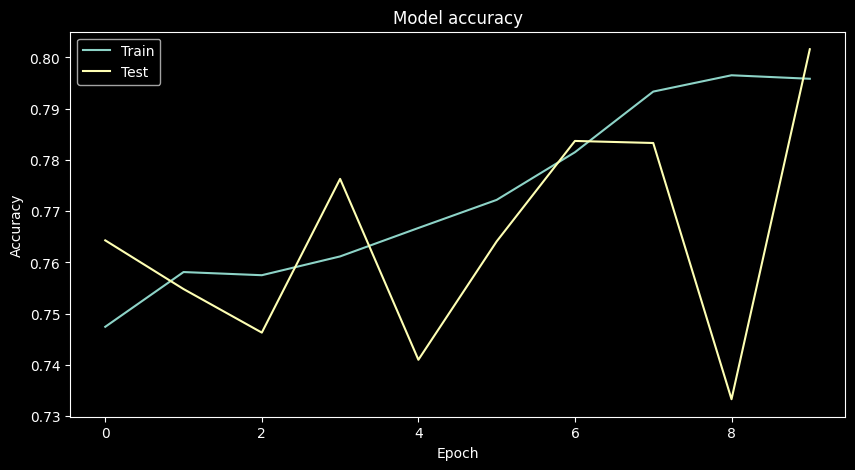

In [79]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

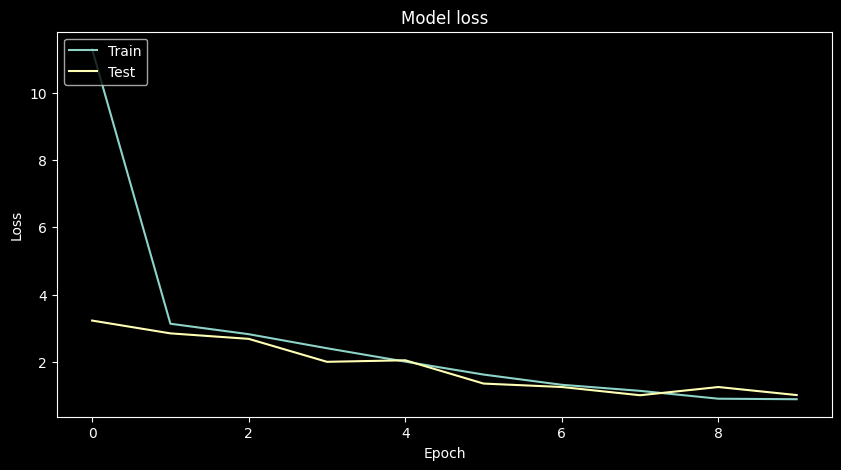

In [80]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [81]:
# Получение предсказанных вероятностей
predicted_probs = model.predict(x_val_float)
# Преобразование вероятностей в индексы классов
predicted_classes = np.argmax(predicted_probs, axis=1)
# Вычисление точности
accuracy = accuracy_score(y_val, predicted_classes)
print('Test Accuracy:', accuracy)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
Test Accuracy: 0.8016


Что вам необходимо сделать:
1. Обучите сеть без скрытых слоев. (Построить аналог обычной линейной модели) **Какое accuracy на валидации получили?**
2. Обучите сеть с двумя скрытыми слоями по 128 нейронов в каждом. **Какое accuracy на валидации получили?**
3. **Сколько параметров в последней сети?**

Удачи!